# Setup SW4

Took Kate's notebook based on the UO SW4 group work; slurm job and runfile for SW4 from SVI Bostock's NLLoc locs

Some notes:
- The topography I have is too small for the full area of Bostock's catalog
- We are not using the inteporlated version used for NLLoc for the 3D Model

In [169]:
import numpy as np
from obspy.geodetics.base import gps2dist_azimuth, kilometer2degrees
from obspy.imaging.beachball import beachball
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import sw4FileFunctions as sff
from sw4_tools import calculate_moment_tensor
base_dir = '/Users/lpapin/Documents/phd/projects/sw4/nonlinloc/'

## Talapas stuff

In [170]:
mem_per_cpu=16 # I fix the memory per cpu and then ramp up the number of tasks
tasks_lowerlim=4 # smalllest number of tasks you want the job to run on, probably gonna be more
percentbuffer=1.30 # Buffer on memory allocation in Slurm, dividing up the calcualtions increases the memory requirement and this stops OOM errors
partition_name="amt" 
time_maximum="3-00:00:00"
account_name="amt" 
# additional model stuff
turn_off_topography = False
simulation_duration=15 #how many seconds do we compute waveforms for
use_velocity3D=True
# output formats
usgsformat=0 # 1 to output textfiles, 0 to sepress output
sacformat=1 # 1 to output sac files, 0 to supress output

## What do we want?

So we decide the family we want to simulate the waveforms of with its mean magnitude over all events, and which focal mechanism we want to see by defining the angles strike, dip, and rake. They are then convert in moment tensor components and we also compute the moment magnitude M0, using Pyrocko.

In [171]:
# Which family from Bostock?
family='099'
# Which magnitude Mw?
Mw=1.75
# Which angles (strike/dip/rake)?
strike = 310
dip = 25
rake = 77

In [172]:
moment_tensor, m0 = calculate_moment_tensor(strike, dip, rake, magnitude=Mw)
print("Moment tensor components for input file:")
print(moment_tensor)
print("!! If the values are <1 it is normalized")

Moment tensor components for input file:
{'mxx': '-0.34', 'myy': '-0.40', 'mzz': '+0.746', 'mxy': '-0.38', 'mxz': '+0.349', 'myz': '+0.559'}
!! If the values are <1 it is normalized


### Beach ball visualization

**!! Why is it not matching with this [Wolfram Focal Mechanism](https://demonstrations.wolfram.com/EarthquakeFocalMechanism/). Can it be the Pyrocko conversion?**

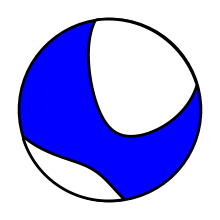

In [173]:
desired_order = ['mxx', 'mxy', 'mxz', 'myy', 'myz', 'mzz']
moment_list = [float(moment_tensor[comp]) for comp in desired_order]
f1=beachball(moment_list)

## Event and Station Locations

### Events

Loading all the events locations (lfe_families in Bostock's case) and choosing the one that will be computed.

In [174]:
# Read in event location file
eventLocs = pd.read_csv(base_dir + 'NLLoc_Bostock/locations.txt',
                        usecols=[0, 1, 2, 3, 4], names=['lfe_family','lat', 'lon', 'depth', 'rms'], header=0)
eventLocs['lfe_family']=eventLocs['lfe_family'].astype(str).str.zfill(3)
eventLocs

,lfe_family,lat,lon,depth,rms
0,001,48.423666,-123.917902,32.372559,0.071229
1,002,48.422867,-123.587693,35.248535,0.102789
2,003,48.184047,-123.526643,30.996419,0.157973
3,005,48.484357,-123.803422,34.521810,0.100317
4,006,48.462685,-123.945840,31.800456,0.061192
...,...,...,...,...,...
125,296,48.378417,-123.492724,37.737956,0.094714
126,297,48.388736,-123.526784,35.696940,0.136967
127,298,48.811199,-123.689150,42.330241,0.098607
128,299,48.885676,-123.880089,40.366536,0.146204


In [175]:
# Multiple events? (if you only have one set this to false so that we dont try to plot those)
multipleEvents=False ###just for the plot but also the limits
#Pick Which Event to Model, or just put your event here
event=eventLocs.loc[eventLocs['lfe_family'] == family].squeeze()
print(event)
# In addition to Event Locations Also feed me the maximum frequency you want to model
freqMax=4 #Hz ###

lfe_family           099
lat            48.465105
lon          -123.898463
depth          32.094238
rms             0.087878
Name: 43, dtype: object


### Stations

Loading all the stations on SVI.

In [176]:
stas=pd.read_csv(base_dir+'stations.csv', usecols=[1, 2, 3, 4],
                    names=['sta', 'lat', 'lon', 'elev'], header=0, delimiter='|')
stas

,sta,lat,lon,elev
0,BPCB,48.9236,-123.704500,31.0
1,GLBC,48.3960,-123.636300,100.0
2,JRBC,48.3957,-123.960000,20.0
3,LCBC,48.4834,-124.261900,100.0
4,KHVB,48.5688,-123.466300,39.0
5,MGCB,48.6317,-123.680800,236.0
6,PHYB,49.0828,-123.843100,39.0
7,SHDB,48.7970,-123.636000,55.0
8,SHVB,48.4723,-123.636000,69.0
9,SOKB,48.3947,-123.673100,45.0


### Plot Events and Stations

We decide which stations we want to simulate the waveforms. *Try to make it match a rectangle not too big*

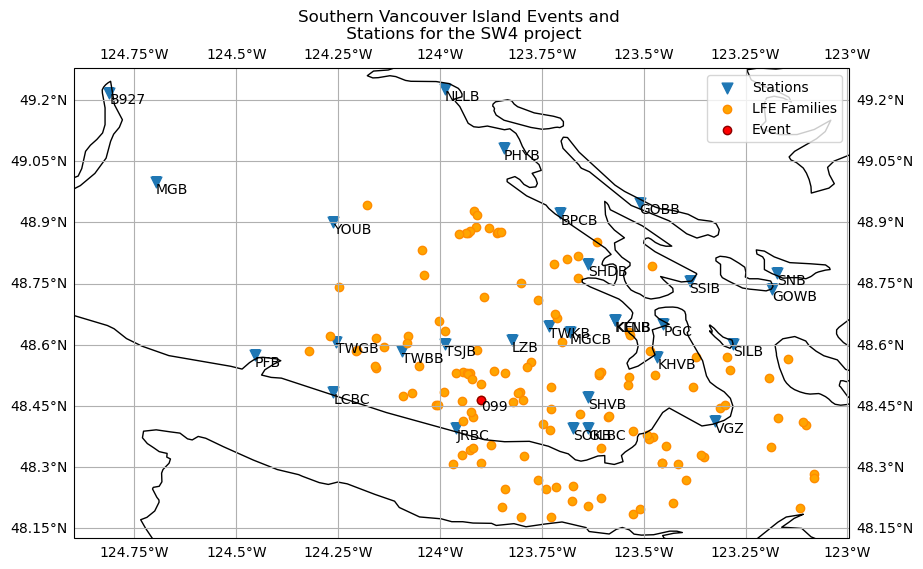

In [177]:
#%matplotlib widget
# Plotting the families and the stations
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
#plt.scatter(stas_full['lon'], stas_full['lat'], marker='v', color='grey', s=50,label='All Stations')
plt.scatter(stas['lon'],stas['lat'],marker='v',s=60,label='Stations')
[plt.text(i, j, f'{name}', va='top', ha='left') for (i, j, name) in zip(stas['lon'], stas['lat'], stas['sta'])]
plt.scatter(eventLocs['lon'], eventLocs['lat'], marker='o', edgecolors='darkorange', facecolors='orange', label='LFE Families')
if event.any():
    plt.scatter(event['lon'], event['lat'], marker='o', edgecolors='darkred', facecolors='red', label='Event')
    plt.text(event['lon'], event['lat'],f"{event['lfe_family']}", va='top', ha='left')
ax.legend()
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
plt.title('Southern Vancouver Island Events and \n Stations for the SW4 project')
plt.savefig(base_dir + 'map_evsta_SVI.png', dpi=300)
plt.show()

In [178]:
# Which stations?
names=['LZB','MGCB','TSJB','TWBB','TWKB','KLNB']
# Choose subset of stations
stas=stas.query('sta in @names').reset_index(drop=True)

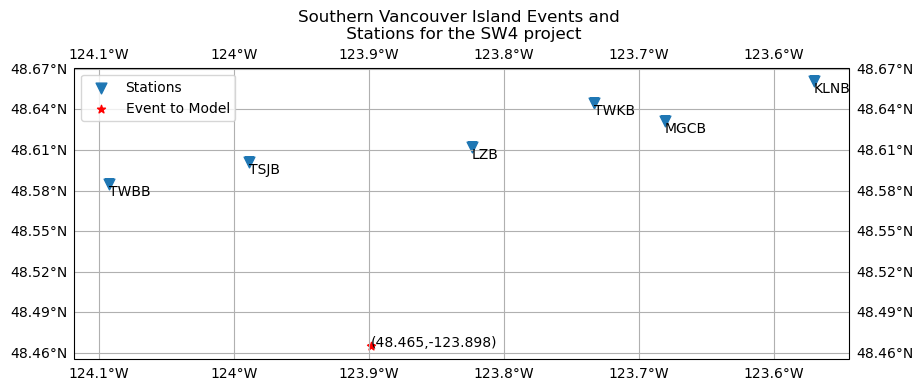

In [179]:
# Plotting the families and the stations
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
#plt.scatter(stas_full['lon'], stas_full['lat'], marker='v', color='grey', s=50,label='All Stations')
plt.scatter(stas['lon'],stas['lat'],marker='v',s=60,label='Stations')
[plt.text(i, j, f'{name}', va='top', ha='left') for (i, j, name) in zip(stas['lon'], stas['lat'], stas['sta'])]
if multipleEvents:
    plt.scatter(eventLocs['lon'],eventLocs['lat'],marker='o',edgecolors='darkorange',facecolors='orange',label='Event Locations')
plt.scatter(event['lon'],event['lat'],marker='*',facecolors='red',label="Event to Model")
plt.text(event['lon'],event['lat'],f"({event['lat']:.3f},{event['lon']:.3f})")
ax.legend(loc='best')
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
plt.title('Southern Vancouver Island Events and \n Stations for the SW4 project')
plt.show()

In [180]:
# These values are roughly the rectangle that encompasses all of our points plus a little buffer
Plotlims=ax.get_extent()
lonMin_ini, lonMax_ini, latMin_ini, latMax_ini=Plotlims
# setup points for box for domain from above with only event and stations
x_ini=[Plotlims[0],Plotlims[1],Plotlims[1],Plotlims[0],Plotlims[0]]
y_ini=[Plotlims[2],Plotlims[2],Plotlims[3],Plotlims[3],Plotlims[2]]
print(lonMin_ini, lonMax_ini, latMin_ini, latMax_ini)

-124.11807 -123.54453 48.45530525 48.67089975


Careful when choosing the event and the stations, if they are too close the limits of the plot might be so close that when filtering you don't get a subset at all from the velocity model.

## 3D Velocity Model

!! Loading as it is and **not** using the inteporlated version used for NLLoc, will see to do that later.

In [181]:
# Load the model and get a subset
velmodel=pd.read_csv(base_dir+'Savard_VpVs.txt', sep='\s+',header=None, names=['lon', 'lat', 'depth', 'vp', 'vs', 'DWS'])
velmodel = velmodel.drop(columns=['DWS'])
print(velmodel, '\nbecomes')
velmodel_subset=velmodel[(velmodel['lat']>=latMin_ini)&(velmodel['lat']<=latMax_ini)&(velmodel['lon']<=lonMax_ini)&(velmodel['lon']>=lonMin_ini)]
velmodel_subset['vp/vs'] = velmodel_subset['vp'] / velmodel_subset['vs']
print(velmodel_subset)

              lon        lat  depth        vp        vs
0     -126.672510  46.951514    0.0  4.956299  2.864755
1     -126.675741  47.077409    0.0  4.966347  2.870762
2     -126.678979  47.203304    0.0  4.976305  2.876411
3     -126.681999  47.320203    0.0  4.968136  2.871618
4     -126.685262  47.446098    0.0  4.957817  2.865878
...           ...        ...    ...       ...       ...
36987 -120.554069  50.494531   93.0  8.245674  4.766323
36988 -120.549634  50.620422   93.0  8.249911  4.768947
36989 -120.545500  50.737325   93.0  8.257427  4.772954
36990 -120.541032  50.863220   93.0  8.261029  4.774880
36991 -120.536556  50.989115   93.0  8.264282  4.776913

[36992 rows x 5 columns] 
becomes
              lon        lat  depth        vp        vs     vp/vs
523   -123.945719  48.543172    0.0  5.312051  3.162173  1.679874
524   -123.945646  48.669067    0.0  5.535789  3.240201  1.708471
557   -123.769295  48.543172    0.0  5.553372  3.144971  1.765794
558   -123.769010  48.669067 

/var/folders/f_/9ygytkln26v3cbhb6ytsqcjc0000gq/T/ipykernel_39413/529848378.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  velmodel_subset['vp/vs'] = velmodel_subset['vp'] / velmodel_subset['vs']


Because we are trying to save memory any place we can, we will take the time to just query the part of the velocity model of interest in hopes that the mimimum Vs in our model space is higher than the absolute minimum Vs in the entire velocity model. We will us the lat and lon limits `_ini` for the inital box before adding the supergrid buffer

In [182]:
# Assign some values from the velocity model for later
# We need Vs min for computing the desired resolution for the domain
# We need the max Vp/Vs ratio, becuase the number of points per wavelength you need for good resolution is higher for high Vp/Vs
vs_min=velmodel_subset['vs'].min()
ind=velmodel_subset.index[velmodel_subset['vp/vs']==velmodel_subset['vp/vs'].max()]
Vp_fromvpvs_max=velmodel['vp'][ind]
Vs_fromvpvs_max=velmodel['vs'][ind]
val=(Vs_fromvpvs_max**2)/(Vp_fromvpvs_max**2-2*Vs_fromvpvs_max**2)
depth_max=velmodel['depth'].max()
val

16776    0.832656
dtype: float64

If val here was <0.1 then we'd have to worry about needing wayyyyy more points per wavelength (like 40 instead of 6-10), but we are okay here

See ref: H.-O. Kreiss and N.A. Petersson. Boundary estimates for the elastic wave equation in almost incompressible materials. SIAM J. Numer. Anal., 50:1556–1580, 2012.

### Plot bounds of Velocity Model with station locations

In [183]:
# Get bounds of velocity model used for the region (cf other notebooks)
latMin, latMax, lonMin, lonMax = 48, 49.3, -124.9, -123
velmodel_svi = velmodel[(velmodel['lat']>=latMin)&(velmodel['lat']<=latMax)&(velmodel['lon']<=lonMax)&(velmodel['lon']>=lonMin)]
velmodel_svi.sort_values(['lat', 'lon']).reindex()

# get lats and lons for our corners of the vmodel
lon_llc=velmodel_svi[velmodel_svi['lat']==velmodel_svi['lat'].min()]['lon'].min()
lon_lrc=velmodel_svi[velmodel_svi['lat']==velmodel_svi['lat'].min()]['lon'].max()
lon_urc=velmodel_svi[velmodel_svi['lat']==velmodel_svi['lat'].max()]['lon'].max()
lon_ulc=velmodel_svi[velmodel_svi['lat']==velmodel_svi['lat'].max()]['lon'].min()

lat_llc=velmodel_svi['lat'].min()
lat_lrc=velmodel_svi['lat'].min()
lat_urc=velmodel_svi['lat'].max()
lat_ulc=velmodel_svi['lat'].max()

# Construct the values to draw a box
x_vmod=[lon_llc, lon_lrc, lon_urc, lon_ulc, lon_llc]
y_vmod=[lat_llc, lat_lrc, lat_urc, lat_ulc, lat_llc]
print(np.min(x_vmod), np.max(x_vmod))
print(np.min(y_vmod), np.max(y_vmod))

-124.861165 -123.015812
48.057585 49.271562


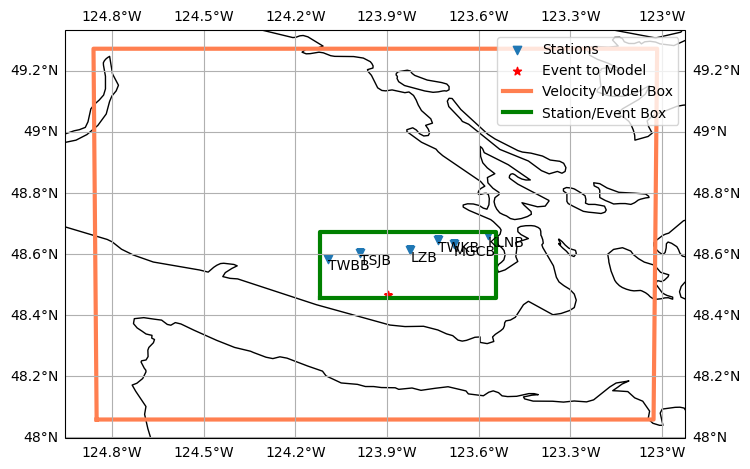

In [184]:
# Map of all data + grids
fig=plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(stas['lon'],stas['lat'],marker='v',label='Stations')
# Add station labels
[plt.text(i, j, f'{sta}',va='top',ha='left') for (i, j,sta) in zip(stas['lon'],stas['lat'],stas['sta'])]
if multipleEvents:
    plt.scatter(eventLocs['lon'],eventLocs['lat'],marker='o',edgecolors='darkorange',facecolors='orange',label='Event Locations')
plt.scatter(event['lon'],event['lat'],marker='*',facecolors='red',label="Event to Model")
ax.plot(x_vmod, y_vmod, color='coral',lw=3,label='Velocity Model Box')
ax.plot(x_ini, y_ini, color='green',lw=3,label='Station/Event Box')
gl = ax.gridlines(draw_labels=True)
ax.coastlines()
ax.legend(loc='upper right')
plt.show()

## Grid Spacing Math

In [185]:
# This is the relationship from the sw4 manual section 4.5, p 28
# npts should be between 6 and 10

def get_step_size(frequency_max, npts, Vs_min):
    H=Vs_min*1000/(npts*frequency_max)
    return H
    
step_size=get_step_size(freqMax, 10, vs_min)
print(f"Model grid spacing is {step_size} m ")

Model grid spacing is 77.36675 m 


Based on the grid spacing, we can now compute the thickeness of the supergrid layer. The supergrid layers are SUPER important because they help damp reflections on the edges of the domain and dramatically decreases the size of the domain you need and decreases computational time. The supergrid points are PART of your model domain. Default number of supergrid points is 30, less than 20 points will make your solution numerically unstable. Long wavelengths are harder to supress than short wavelengths

In [186]:
npts_supergrid=30
supergrid_thickness=step_size*npts_supergrid
supergrid_thickness_deg=np.round(kilometer2degrees(supergrid_thickness/1000),4)
print(f"Do not put event sources or receivers in the outer {supergrid_thickness} m of the domain \nor a buffer of ~{supergrid_thickness_deg} degrees")

Do not put event sources or receivers in the outer 2321.0025 m of the domain 
or a buffer of ~0.0209 degrees


We care going to add the width of the supergrid as a buffer around our domain

In [213]:
lonMin=lonMin_ini-supergrid_thickness_deg
lonMax=lonMax_ini+supergrid_thickness_deg
latMin=latMin_ini-supergrid_thickness_deg
latMax=latMax_ini+supergrid_thickness_deg

# setup points for box for domain including supergrid buffer
x=[lonMin,lonMax,lonMax,lonMin,lonMin]
y=[latMin,latMin,latMax,latMax,latMin]
print(latMax)

48.691799749999994


## Some topography calculations

First let's draw a box that is slightly bigger than our x,y domain once we've included the supergrid buffer

In [189]:
# setup points for box for domain for elevation if we do adding the buffer from the elevation_snippet script
buffer=0.05
lonMin_topo=lonMin-buffer
lonMax_topo=lonMax+buffer
latMin_topo=latMin-buffer
latMax_topo=latMax+buffer

# setup points for box for topo domain
x_topo=[lonMin_topo,lonMax_topo,lonMax_topo,lonMin_topo,lonMin_topo]
y_topo=[latMin_topo,latMin_topo,latMax_topo,latMax_topo,latMin_topo]

We need to find the minimum and maximum elevations in our topography to calculate zmax

In [190]:
# read topo from netcdf
file2load_topo='VCI_topo_03s.nc'
grid_big = xr.open_dataset(file2load_topo)
grid_big

<xarray.Dataset> Size: 8MB
Dimensions:    (lon: 1671, lat: 1136)
Coordinates:
  * lon        (lon) float64 13kB -124.3 -124.3 -124.3 ... -122.9 -122.9 -122.9
  * lat        (lat) float64 9kB 47.98 47.98 47.98 47.98 ... 48.92 48.92 48.92
Data variables:
    elevation  (lat, lon) float32 8MB ...

In [191]:
grid=grid_big.loc[dict(lat=slice(latMin_topo, latMax_topo),lon=slice(lonMin_topo, lonMax_topo))]
grid['elevation'].data.shape

(429, 858)

In [192]:
df_grid = grid.to_dataframe().reset_index().sort_values(['lat', 'lon'])
# df_grid_small=df_grid[(df_grid['lat']<=lat_max+buffer)&(df_grid['lat']>=lat_min-buffer)&(df_grid['lon']<=lon_max+buffer)&(df_grid['lon']>=lon_min-buffer)].reset_index().sort_values(['lat', 'lon'])
elev_max=df_grid['elevation'].max()
elev_min=df_grid['elevation'].min()
lontopo_max=df_grid['lon'].max()
lontopo_min=df_grid['lon'].min()
lattopo_max=df_grid['lat'].max()
lattopo_min=df_grid['lat'].min()
print(f"Minimum elevation is {elev_min} m and the maximum elevation is {elev_max} m")

Minimum elevation is -459.4246520996094 m and the maximum elevation is 1114.0 m


Equation for what to set z_max in the topography command:
egrid ≤ emin − 3(emax − emin), emin ≤ e(x, y) ≤ emax

In [193]:
def calc_topo_zmax(emin,emax):
    egrid=emin-3*(emax-emin)
    zmax=-egrid
    return zmax
z_max=calc_topo_zmax(elev_min,elev_max)
z_max

5179.698699951172

## Revisit Velocity Model

We are going to trim the velocity model to be 0.01 degrees bigger than topography model. This is to allow for the fact that sometimes we end up with a little bigger topography model than we call because of how pygmt pulls it's data.

In [194]:
velocity_buffer=0.01
lonMin_vmod_trim=lonMin_topo-velocity_buffer
lonMax_vmod_trim=lonMax_topo+velocity_buffer
latMin_vmod_trim=latMin_topo-velocity_buffer
latMax_vmod_trim=latMax_topo+velocity_buffer

# setup points for box for topo domain
x_vmod_trim=[lonMin_vmod_trim,lonMax_vmod_trim,lonMax_vmod_trim,lonMin_vmod_trim,lonMin_vmod_trim]
y_vmod_trim=[latMin_vmod_trim,latMin_vmod_trim,latMax_vmod_trim,latMax_vmod_trim,latMin_vmod_trim]

### Add topography to our plot

**!! Add a warning if topo not large enough**

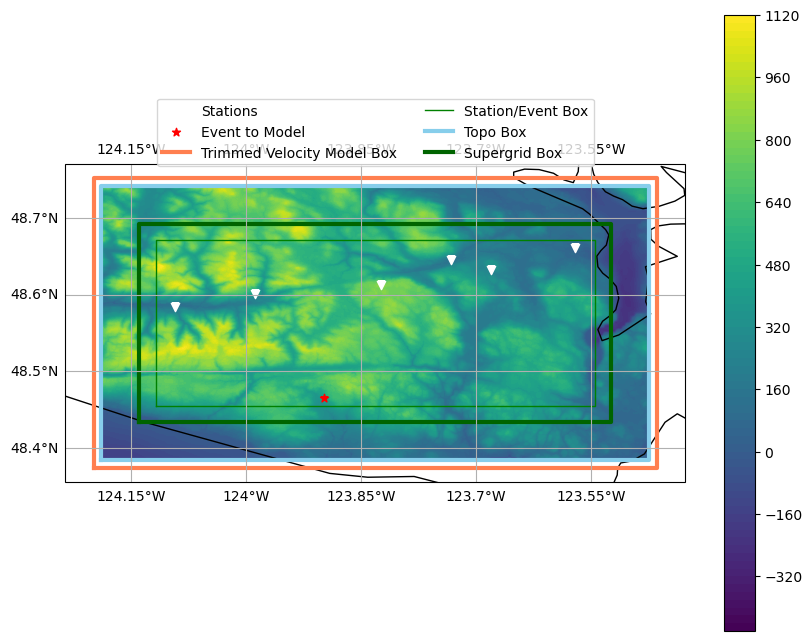

In [195]:
fig=plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(grid.lon, grid.lat,grid.elevation,100)
plt.colorbar()
plt.scatter(stas['lon'],stas['lat'],marker='v',facecolors='white',label='Stations')
# Add station labels
# [plt.text(i, j, f'{sta}',va='top',ha='left') for (i, j,sta) in zip(stas['lon'],stas['lat'],stas['sta'])]
if multipleEvents:
    plt.scatter(eventLocs['lon'],eventLocs['lat'],marker='o',edgecolors='darkorange',facecolors='orange',label='Event Locations')
plt.scatter(event['lon'],event['lat'],marker='*',facecolors='red',label="Event to Model")
ax.plot(x_vmod_trim, y_vmod_trim, color='coral',lw=3,label='Trimmed Velocity Model Box')
ax.plot(x_ini, y_ini, color='green',lw=1,label='Station/Event Box')
ax.plot(x_topo, y_topo, color='skyblue',lw=3,label='Topo Box')
ax.plot(x, y, color='darkgreen',lw=3,label='Supergrid Box')
gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
ax.coastlines()
ax.legend(loc='center', bbox_to_anchor=(0.5, 1.1), ncol=2)
plt.show()
fig.savefig(f"supermap.png", dpi=300, bbox_inches="tight")

## Aggregate Info for .in Files

In [196]:
name='fam'+event['lfe_family']+'_'+str(len(stas))+'stas'

### Grid Command info

Specifying the coordinates for grid on surface

In [197]:
# Compute cartesian locations for source
X,_,_= gps2dist_azimuth(latMin, lonMin, latMin, lonMax)
Y,_,_= gps2dist_azimuth(latMin, lonMin, latMax, lonMin)
X,Y=np.round(X,-1),np.round(Y,-1)
print(f"x and y in m {Y,X }")
print(f"lat lon of lower left corner {latMin:.3f},{lonMin:.3f}")
print(f"lat lon of upper right corner {latMax:.3f},{lonMax:.3f}")
print(f"Model grid spacing should be at least {step_size:.0f} m for a frequency max of {freqMax} Hz")

x and y in m (28620.0, 45530.0)
lat lon of lower left corner 48.434,-124.139
lat lon of upper right corner 48.692,-123.524
Model grid spacing should be at least 77 m for a frequency max of 4 Hz


/var/folders/f_/9ygytkln26v3cbhb6ytsqcjc0000gq/T/ipykernel_39413/503445679.py:2: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  X,_,_= gps2dist_azimuth(latMin, lonMin, latMin, lonMax)
/var/folders/f_/9ygytkln26v3cbhb6ytsqcjc0000gq/T/ipykernel_39413/503445679.py:3: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  Y,_,_= gps2dist_azimuth(latMin, lonMin, latMax, lonMin)


For the model depth I'm using the event depth plus a buffer of 2 times the width of the supergrid layer. I made that up

In [198]:
print(f"Maximum depth based on velocity model {depth_max} km")
domainDepth=np.round((np.abs(event['depth']*1000)+2*supergrid_thickness),-3)
print(f"We are using {domainDepth/1000} km as the depth of our model")

Maximum depth based on velocity model 93.0 km
We are using 37.0 km as the depth of our model


In [199]:
grid_cmd=f"grid x={Y} y={X} z={domainDepth} lat={latMin:.3f} lon={lonMin:.3f} az=0 h={step_size:.0f}\n"
print(grid_cmd)

grid x=28620.0 y=45530.0 z=37000.0 lat=48.434 lon=-124.139 az=0 h=77



### Material Model Command Info

In [200]:
if use_velocity3D:
    sff.generate_pfile(velmodel, name, lonMin_vmod_trim, lonMax_vmod_trim, latMin_vmod_trim, latMax_vmod_trim)

In [201]:
block_cmd=""
if use_velocity3D:
    pfile_cmd=f"{block_cmd}pfile filename={name}.ppmod\n"
else:
    pfile_cmd=block_cmd
print(pfile_cmd)

pfile filename=fam099_6stas.ppmod



### Topography Command Info

zmax is the value that sw4 uses for making its curvilinear grid

In [202]:
print(f"zmax is {np.round(z_max,3)}")

zmax is 5179.699


Generate the smaller topography file ending in `.topo` from netcdf file that is the size of the velocity model

In [203]:
sff.write_topo(file2load_topo, name, lonMin_topo, lonMax_topo, latMin_topo, latMax_topo)

In [204]:
topo_cmd=f"topography input=grid file={name}.topo zmax={z_max:.3f} order=3\n"
print(topo_cmd)

topography input=grid file=fam099_6stas.topo zmax=5179.699 order=3



### Source Command Info

I'm making numerical green's functions so I run each of the six components of the MT 

In [205]:
sourcetype = "RickerInt"
gf_components = ["mxx", "myy", "mzz", "mxy", "mxz", "myz"]
eventLat, eventLon = event['lat'], event['lon']
eventDepth = np.abs(event['depth'] * 1000)
source_cmd_list = []

for component in gf_components:
    src_cmd = (
        f"source lat={eventLat:.3f} lon={eventLon:.3f} "
        f"depth={eventDepth} m0={m0} {component}={moment_tensor[component]} "
        f"type={sourcetype} t0=0 freq={freqMax}"
    )
    source_cmd_list.append(src_cmd)
    print(src_cmd)

source lat=48.465 lon=-123.898 depth=32094.237999999998 m0=473151258961.4774 mxx=-0.34 type=RickerInt t0=0 freq=4
source lat=48.465 lon=-123.898 depth=32094.237999999998 m0=473151258961.4774 myy=-0.40 type=RickerInt t0=0 freq=4
source lat=48.465 lon=-123.898 depth=32094.237999999998 m0=473151258961.4774 mzz=+0.746 type=RickerInt t0=0 freq=4
source lat=48.465 lon=-123.898 depth=32094.237999999998 m0=473151258961.4774 mxy=-0.38 type=RickerInt t0=0 freq=4
source lat=48.465 lon=-123.898 depth=32094.237999999998 m0=473151258961.4774 mxz=+0.349 type=RickerInt t0=0 freq=4
source lat=48.465 lon=-123.898 depth=32094.237999999998 m0=473151258961.4774 myz=+0.559 type=RickerInt t0=0 freq=4


### Receiver Output Command Info

In [206]:
# set output type
out='displacement'
rec_cmd_list=[]
for comp in gf_components:
    rec_cmd=""
    for i in range(len(stas)):
        rec_cmd=rec_cmd+f"rec lat={stas['lat'][i]:.3f} lon={stas['lon'][i]:.3f} depth=0 nsew=1 variables={out} file={stas['sta'][i]}_{comp} usgsformat={usgsformat} sacformat={sacformat}\n"
    print(rec_cmd)
    rec_cmd_list.append(rec_cmd)

rec lat=48.632 lon=-123.681 depth=0 nsew=1 variables=displacement file=MGCB_mxx usgsformat=0 sacformat=1
rec lat=48.585 lon=-124.092 depth=0 nsew=1 variables=displacement file=TWBB_mxx usgsformat=0 sacformat=1
rec lat=48.612 lon=-123.824 depth=0 nsew=1 variables=displacement file=LZB_mxx usgsformat=0 sacformat=1
rec lat=48.661 lon=-123.571 depth=0 nsew=1 variables=displacement file=KLNB_mxx usgsformat=0 sacformat=1
rec lat=48.601 lon=-123.989 depth=0 nsew=1 variables=displacement file=TSJB_mxx usgsformat=0 sacformat=1
rec lat=48.645 lon=-123.733 depth=0 nsew=1 variables=displacement file=TWKB_mxx usgsformat=0 sacformat=1

rec lat=48.632 lon=-123.681 depth=0 nsew=1 variables=displacement file=MGCB_myy usgsformat=0 sacformat=1
rec lat=48.585 lon=-124.092 depth=0 nsew=1 variables=displacement file=TWBB_myy usgsformat=0 sacformat=1
rec lat=48.612 lon=-123.824 depth=0 nsew=1 variables=displacement file=LZB_myy usgsformat=0 sacformat=1
rec lat=48.661 lon=-123.571 depth=0 nsew=1 variables=dis

!! depth=0 means it's the topography

### Other Command Info

In [207]:
fileio_cmd_list=[]
infilename_list=[]
verbosity=0
for comp in gf_components:
    outdir=name+"_results_"+comp
    fileio_cmd=f"fileio path={outdir} verbose={verbosity}\n"
    fileio_cmd_list.append(fileio_cmd)
    infilename=f"{name}_{comp}"
    infilename_list.append(infilename)
time_cmd=f"time t={simulation_duration} \n"

## Last Calculations

### Memory Calculations

Appendix B says roughly 208 bytes/grid point for runs with topography 

BUT "For parallel runs, the memory per grid point will be somewhat higher, because of duplicatedghost points at the processor boundaries."

In [208]:
grid_pts=(X/step_size)*(Y/step_size)*(domainDepth/step_size)
mem_per_point=208
mem_gb=np.round(grid_pts*mem_per_point/1e9,2)
print(f"Rough approximation of memory is {mem_gb} GB for a maximum frequency of {freqMax} Hz")
min_tasks=np.max([np.ceil(mem_gb*percentbuffer/mem_per_cpu),tasks_lowerlim])
print(f"{min_tasks} is the smallest number of tasks we can assign")
tot_mem=mem_per_cpu*(min_tasks)
print(f"{tot_mem} total memory request")

Rough approximation of memory is 21.66 GB for a maximum frequency of 4 Hz
4.0 is the smallest number of tasks we can assign
64.0 total memory request


### Maximum Grid spacing

To have 30 super grid points on the outside of the domain and at least 60 actual grid points in domain, you can't have a step size for your grid higher than:

In [209]:
h_max=np.min([X/120,Y/120,depth_max*1000/90])
h_max

238.5

## Output Files

### Runfile 

In [210]:
if turn_off_topography:
    # this line will comment out the topography command if you need to
    topo_cmd= ("#"+topo_cmd)
for i, fname in enumerate(infilename_list):
    fname = fname+".in"
    file=open(fname,'w')
    file.write(f"# SW4 input file \n"+
                "# The grid command defines the model domain \n"+
                grid_cmd+
                "# The fileio command specifies output directory and how much text the code spits out while it runs \n"+
                fileio_cmd_list[i]+
                "# The topography reads in the topography model we use \n"+
                topo_cmd+
                "# The pfile command reads the velocity model in \n"+
                pfile_cmd+
                "# the source sets up the event information \n"+
                source_cmd_list[i]+
                "# The time command sets model start time (certain STFs require t0>0 to avoid numerical nonsense) \n"+
                time_cmd+
                "# The rec command set where stations are \n"+
                rec_cmd_list[i])
    file.close()

### Talapas

In [211]:
# Create the job slurm script
partitionline=f"#SBATCH --partition={partition_name}     ### Quality of Service (like a queue in PBS)\n"
timeline=f"#SBATCH --time={time_maximum}      ### Wall clock time limit in Days-HH:MM:SS\n"
taskline=f"#SBATCH --ntasks={int(min_tasks)}     ### Number of tasks to be launched per Node\n"
memoryline=f"#SBATCH --mem-per-cpu={int(mem_per_cpu)}G\n"
accountline=f"#SBATCH --account={account_name}\n"
mailline1="#SBATCH --mail-type=END,FAIL\n"
mailline2="#SBATCH --mail-user=lpapin@uoregon.edu\n\n"
fname_slurm_list = []
for i, fname in enumerate(infilename_list):
    fname_slurm="submit_"+fname
    fname_in=fname+".in"
    jobname=str(i)+"sw4"+name[:6]
    jobnameline=f"#SBATCH --job-name={jobname}    ### Job Name\n"
    runline=f"mpirun -np $SLURM_NTASKS sw4 {fname_in}"
    file=open(fname_slurm,'w')
    file.write(f"#!/bin/bash\n"+
               jobnameline+
               partitionline+
               timeline+
               taskline+
               memoryline+
               accountline+
               mailline1+
               mailline2+
               f"module load sw4/3.0.0\n"+
               runline)
    file.close()
    fname_slurm_list.append(fname_slurm)

In [212]:
# Create the master submit script (= run all jobs)
with open("submit_all_jobs.sh", 'w') as master_file:
    master_file.write("#!/bin/bash\n\n")

    # Add chmod +x lines
    chmod_line = "chmod +x " + " ".join(fname_slurm_list) + "\n"
    master_file.write(chmod_line)

    # Add sbatch commands
    for fname_slurm in fname_slurm_list:
        master_file.write(f"sbatch {fname_slurm}\n")

    # Add squeue command
    master_file.write("\nsqueue -u lpapin\n")

print("Master submit script 'submit_all_jobs.sh' created successfully.")

Master submit script 'submit_all_jobs.sh' created successfully.


Copy/paste this to launch everything:
<br> `chmod +x submit_all_jobs.sh` <br>
`./submit_all_jobs.sh`
